## **Tools to develop EEG event detection pipelines**
## See more detail about workshop here: thinknew.github.io/BCIWorkshop2024/

### Purpose
**This notebook aims to demonstrate usage of pre-developed code for time-series classification, specifically:**

* Demonstrate a preprocessing pipeline
* Develop and tune your own deep learning classification pipeline
* Evaluate the performance of applied methods

# Setting Up the Environment
The prerequisite packages to this tutorial are:


*   [**MNE**](https://mne.tools/stable/install/mne_python.html#installing-mne-python-and-its-dependencies): EEG Data Package
*   [**NumPy**](https://www.scipy.org/install.html): Numerical Computing (SciPy Download Page)
*   [**SciPy**](https://www.scipy.org/install.html): Scientific Computing
*   [**MatPlotLib**](https://matplotlib.org/users/installing.html): General Purpose Machine Learning Library
*   [**Scikit-Learn**](https://scikit-learn.org/stable/install.html): General Purpose Machine Learning Library
*   [**Tensorflow 2.0**](https://www.tensorflow.org/guide/effective_tf2/): Deep Learning Library from Google Brain
*   [**PyWavelets**](https://pywavelets.readthedocs.io/): Open source wavelet transform software
*   [**EntropyHub**](https://www.entropyhub.xyz/index.html): Open source toolkit for entropic data analysis

We will use pip to setup the environment. In your own local machine, consider using conda and the environment.yml file.

In [1]:
!pip install EntropyHub
!pip install mne
!pip install seaborn
!pip install PyWavelets
!pip install emd
!pip install pyxdf

Import all of our required modules. Several functions have already been developed for use and are defined in:

* augmentations.py
* dsp.py
* features.py
* models.py
* utils.py


---


**Augmentations**

Contains the numpy implementation of time series data augmentations including transformations, pattern mixing, generative models, and decomposition ([Iwana B.K. & Uchida S., 2021](https://doi.org/10.1371/journal.pone.0254841) )

**Digital Signal Processing (DSP)**

Contains several signal processing functions for filtering, averaging, and transformations typically used in EEG analysis.

**Features**

Contains several calculations covering statisticaly, temporal, and frequency based features. Not all functions support multi-dimensional (> 1-D) calculation. Specifically, sample entropy, approximate entropy, PSD, zero-crossings, and peak functions take 1-D inputs only.

**Models**

Contains basic descriptions of linear and non-linear classification models. All models can be reached via the `'get_model'` function. Scikit-learn models may also be wrapped in a GridSearch hyperparameter optimisation function, see `'set_gridsearch'` and `'get_best_gridsearch'`. Confident users may adapt neural network architectures as desired.

**Utils**

Provides several functions for ease of use including sliding window process, model persistence, and model evaluation among others.

# Environment Setup

In [2]:
import emd
import mne
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from multiprocessing import Pool, cpu_count
from functools import partial
from itertools import repeat

from sklearn.datasets import load_iris

from utils import *
from dsp import run_hht, std_scale, notch_filter, butter_bandpass_filter
from augmentations import *
from features import *
from models import *


In [3]:
# Set random seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
# Set window size and shift
window_size = 1 # seconds
window_shift = 0.25 # seconds

# Pipeline Overview
Steps

1.   Load data
2.   Preprocess
3.   Split dataset
4.   Initialise models
5.   Train
6.   Model persistence
7.   See evaluation



# Load Data

In [5]:
# Load data
eeg_data = "./sample_data/14_06_Allen_open_close_eyes_25Hz.xdf"

(data_dict, marker_dict), header = load_xdf(eeg_data)

fs = get_xdf_fs(data_dict)
print(fs)
fs = 120

marker_labels, marker_timestamps = get_marker_data(marker_dict, re_str='eyes')

data, data_timestamps = get_eeg_data(data_dict)

124.99491110488259


In [6]:
# Set up the preprocessing steps for our data
def preprocess(data, fs, do_plot=False):
    # 5 - 40 bandpass filtering
    filt = butter_bandpass_filter(data, 5, 40, fs=fs, axis=0)

    if do_plot:
        plt.figure(figsize=(10, 7))
        plt.subplot(211)
        plt.plot(data[:, 0])
        plt.plot(filt[:, 0])
        plt.legend(['raw', 'processed'])

        plt.subplot(212)
        plt.title("FFT")
        plt.plot(*run_fft(data[:,0], fs=fs))
        plt.plot(*run_fft(filt[:,0], fs=fs))

        plt.show()

    return filt


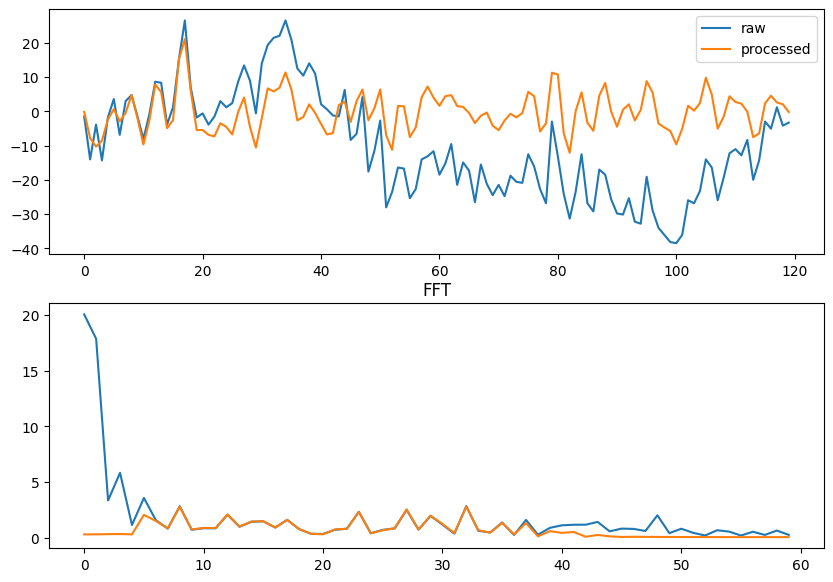

(120, 2)


In [7]:
tmp = preprocess(data[:120, :2], fs, do_plot=True)
print(tmp.shape)

Now we run the preprocessing pipeline on the data before segmenting into windows.

# Pre-process

In [8]:
# segment data
t0_array = marker_timestamps[:-1]
t1_array = marker_timestamps[1:]

keys = np.unique(marker_labels)
data_segments = {int(k): [] for k in keys if not np.isnan(k) and int(k) in
                [0, 1]}

for lbl, t0, t1 in zip(marker_labels[:-1], t0_array, t1_array):
    mask = (data_timestamps >= t0) & (data_timestamps < t1)

    # get timestamps in period of interest
    data_segment = data[mask]

    # preprocess
    data_segment = preprocess(data_segment, fs)

    # create windows from period of interest
    data_wins = get_windows(data_segment, int(window_size*fs),
                            int(window_shift*fs))

    data_segments[int(lbl)].append(data_wins)

n_classes = len(data_segments)

# Create arrays of labels and input data
x, y = [], []
for k, v in data_segments.items():
    x_in = np.vstack(v)
    x.append(x_in)
    y.append(np.repeat(k, len(x_in)))

x = np.concatenate(x, axis=0)
y = np.concatenate(y, axis=0).reshape(-1, 1)

In [9]:
print(x.shape)
print(y.shape)

(799, 120, 11)
(799, 1)


In [10]:
# We only only the EEG channels which can be found in 'get_channel_names'
ch_names = get_channel_names(data_dict)
print(ch_names)

{0: 'F3', 1: 'F4', 2: 'C3', 3: 'Cz', 4: 'C4', 5: 'P3', 6: 'P4', 7: 'BIP', 8: 'accX', 9: 'accY', 10: 'accZ'}


In [11]:
x = x[..., :7]
print(x.shape)

(799, 120, 7)


In [12]:
# For Hilbert-Huang Transform
hht = []
f = []
freq_edges, freq_centres = emd.spectra.define_hist_bins(5, 40, 5*50, 'linear')

# Split Dataset

We split the dataset before completing any feature calculations and transforms. This is to introduce augmentations to the training dataset only.

In [13]:
# Random shuffle split to train and test sets.
x_train, x_test, y_train, y_test = split_dataset(x, y)

In [14]:
def apply_augs(data):
    ''' A function to apply augmentations
    :param data: numpy-like array of shape (N, T, C)'''
    data_augs = jitter(data)
    data_augs = scaling(data_augs)
    return data_augs

In [15]:
def get_my_features(data, fname, m_func):
  '''Returns presaved features from fname suffix, otherwise, calculates features
  and HHT. Features are saved to pkl format and HHT frequency and magnitude is
  saved as .npy
  :param data: 1-D numpy-like array to calculate features and transforms
  :type fname: Filename string suffix for calculations. Typically set as train
  or test.'''
  feat_fname = 'features_'+fname+'.pkl'
  freq_fname = 'freqs_'+fname+'.npy'
  hht_fname = 'hht_' + fname+'.npy'
  try:
    return pd.read_pickle(feat_fname), np.load(freq_fname), np.load(hht_fname)
  except:
    with Pool(cpu_count()) as p:
        tmp_dict = p.map(m_func, data)
        hht = p.starmap(run_hht, zip((data), repeat(freq_edges)))
  # Create train and test dataframes from dictionary inputs
  df = pd.DataFrame(tmp_dict)
  df.replace([np.inf, -np.inf], 0, inplace=True)
  df.replace(np.nan, 0, inplace=True)
  df.to_pickle(feat_fname)

  # Create array of augmented train HHT and non-augmented test HHT
  f, hht_ = zip(*hht)
  f = f[0]
  hht = np.array(hht_)
  np.save('freqs_'+fname, f)
  np.save('hht_'+fname, hht)
  return df, f, hht

In [16]:
m_ch = 6

In [17]:
# apply augmentations
x_train_aug = apply_augs(x_train)
tmp_dict = []
m_func = partial(return_all_features, ch=m_ch)

df_train, f, hht_train = get_my_features(x_train_aug[..., m_ch], 'train', m_func)
df_test, _, hht_test = get_my_features(x_test[..., m_ch], 'test', m_func)

In [18]:
# What does our feature data look like?
print(df_train.head())

   ch6_mean    ch6_std  ch6_median    ch6_max    ch6_min  ch6_pk2pk  ch6_skew  \
0 -0.031379   6.176957   -0.138698  14.534100 -16.648429  31.182529 -0.085356   
1  0.576950  12.769391    0.855323  37.621981 -31.167881  68.789862  0.143293   
2  0.148935   4.371185    0.113379  12.333571 -10.216386  22.549957  0.277157   
3  0.219338   5.682840    0.246385  14.444799 -14.238802  28.683601  0.059268   
4  0.118025   5.674751   -0.628377  20.351702 -10.975792  31.327494  0.807399   

   ch6_kurtosis  ch6_sample_entropy  ch6_approx_entropy  ...    ch6_rms  \
0     -0.582297                 0.0            1.190543  ...   6.177037   
1      0.400148                 0.0            1.190543  ...  12.782418   
2     -0.211059                 0.0            1.190543  ...   4.373722   
3     -0.267386                 0.0            1.190543  ...   5.687071   
4      0.754145                 0.0            1.190543  ...   5.675978   

   ch6_max_freq  ch6_mean_power_band_0  ch6_mean_power_band_1 

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Transform Plot'}>)

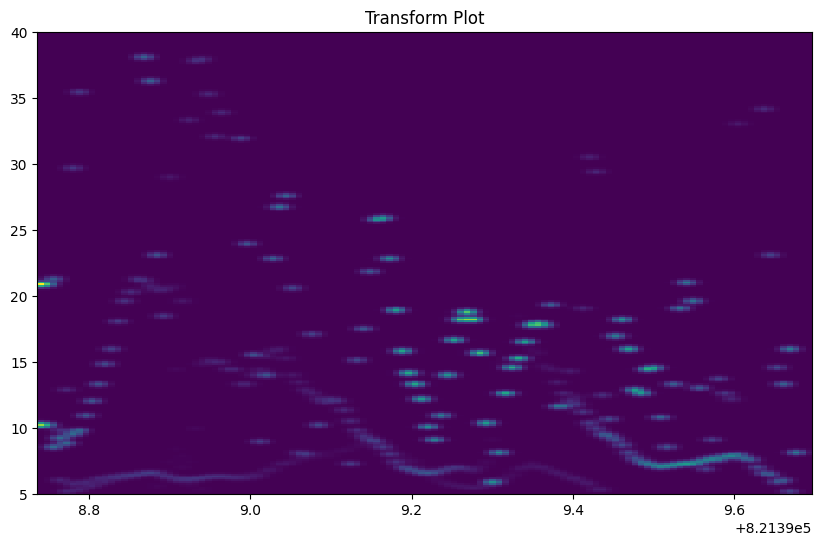

In [19]:
# What does the HHT look like?
plot_channel_transform(data_timestamps[:int(window_size*fs)], f, hht_test[10])

In [20]:
# Setup features for training
x_feats_train = df_train.values.astype('float32')
x_feats_test = df_test.values.astype('float32')

In [21]:
# Perform One Hot Encoding on labels
y_ohe, ohe = do_one_hot(y.reshape(-1, 1))
n_classes = len(np.unique(y))

y_train_ohe = ohe.transform(y_train.reshape(-1,1)).toarray().astype(int)
y_test_ohe = ohe.transform(y_test.reshape(-1,1)).toarray().astype(int)

# Model Initialisation

We have supplied several models for you to use. These can be initialised by specifying any of the following strings into the first argument of `get_model`:

*   svm : Support Vector Machine
*   cca : Canonical Correlation Analysis
*   lda : Linear Dicriminant Analysis
*   tree: Decision Tree
*   nb : Categorical Naive Bayes
*   knn : K Nearest Neighours
*   fnn : Fully connected Neural Network
*   cnn1d : 1-D Convolutional Neural Network
*   cnn2d : 2-D Convolutional Neural Network
*   lstm : Long Short-Term Memory Neural Network
*   attn : Patch input to Attention Encoder Neural Network

Note CNN2D will only work for 2D transformations on data, such as STFT, HHT, or CWT. See dsp.py for functions.

In this example we use FNN and LDA. The FNN model was detailed in `model.py` as:
```
self.model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(32),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(self.n_classes, activation='softmax'),
])

```

In [22]:
fnn = get_model('fnn', n_classes=n_classes)
lda = get_model('lda', n_classes=n_classes)

# Model Training and Evaluation

The fully connected neural network (FNN) trains on the preprocessed and augmented windowed data while the linear discriminant analysis (LDA) model trains on extracted features from augmented training sets.

## Neural Network

In [23]:
fnn.compile_model()
fnn.fit_model(x_train_aug, y_train_ohe, validation_split=0.25)
y_hat_fnn = fnn.model.predict(x_test)

Epoch 1/10
15/15 [==============================] - 5s 97ms/step - loss: 3.2314 - categorical_accuracy: 0.6159 - val_loss: 0.5903 - val_categorical_accuracy: 0.7750
Epoch 2/10
15/15 [==============================] - 1s 69ms/step - loss: 0.4963 - categorical_accuracy: 0.8455 - val_loss: 0.4384 - val_categorical_accuracy: 0.8687
Epoch 3/10
15/15 [==============================] - 1s 74ms/step - loss: 0.1674 - categorical_accuracy: 0.9332 - val_loss: 0.3563 - val_categorical_accuracy: 0.8813
Epoch 4/10
15/15 [==============================] - 1s 54ms/step - loss: 0.0980 - categorical_accuracy: 0.9624 - val_loss: 0.3833 - val_categorical_accuracy: 0.8938
Epoch 5/10
15/15 [==============================] - 1s 53ms/step - loss: 0.0591 - categorical_accuracy: 0.9875 - val_loss: 0.3875 - val_categorical_accuracy: 0.9000
Epoch 6/10
15/15 [==============================] - 1s 68ms/step - loss: 0.0325 - categorical_accuracy: 0.9958 - val_loss: 0.3487 - val_categorical_accuracy: 0.8938
Epoch 7/10

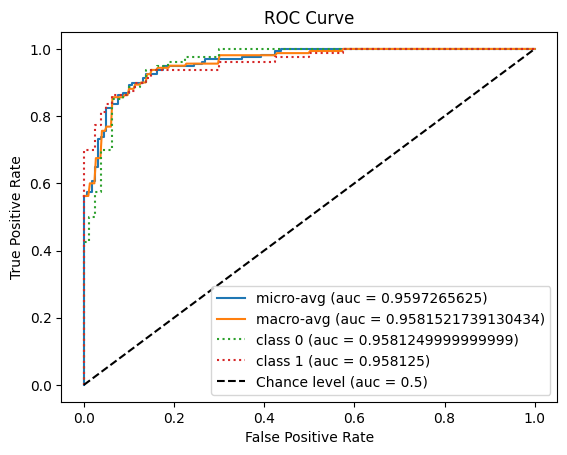

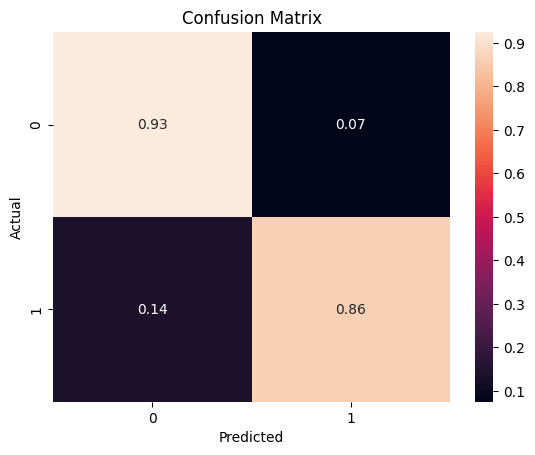

              precision    recall  f1-score   support

           0       0.87      0.93      0.90        80
           1       0.92      0.86      0.89        80

    accuracy                           0.89       160
   macro avg       0.90      0.89      0.89       160
weighted avg       0.90      0.89      0.89       160



In [24]:
plt.figure()
plot_roc_curve(y_test_ohe, y_hat_fnn)

pred = np.argmax(y_hat_fnn, axis=1)
plt.figure()
plot_confusion_matrix(y_test, pred, labels=np.unique(y))

show_classifier_performance(y_test, pred)

## LDA

In [25]:
lda.fit(x_feats_train, y_train)
y_hat_lda = lda.predict_proba(x_feats_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


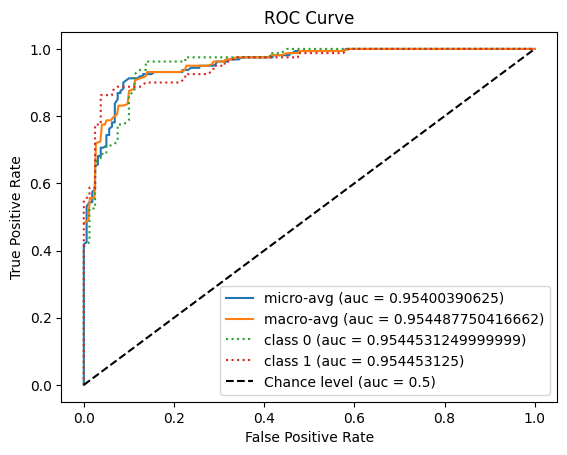

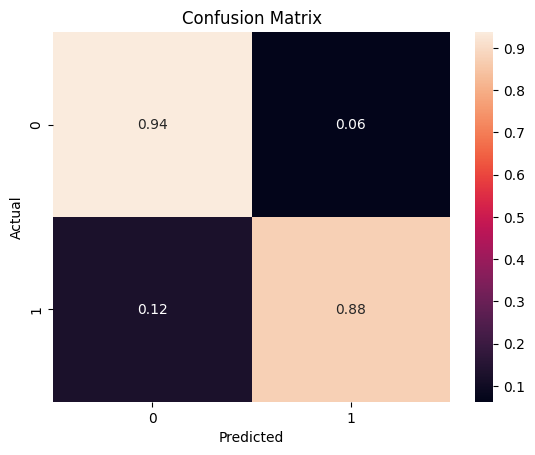

              precision    recall  f1-score   support

           0       0.88      0.94      0.91        80
           1       0.93      0.88      0.90        80

    accuracy                           0.91       160
   macro avg       0.91      0.91      0.91       160
weighted avg       0.91      0.91      0.91       160



In [26]:
plt.figure()
plot_roc_curve(y_test_ohe, y_hat_lda)

pred = np.argmax(y_hat_lda, axis=1)
plt.figure()
plot_confusion_matrix(y_test, pred, labels=np.unique(y))

show_classifier_performance(y_test, pred)

# Model Persistence

Simply aim to save and load our models for use elsewhere. For your project, consider saving with easy to recognise naming.

In [32]:
# Save models for later use
save_model(fnn.model, 'fnn')
save_model(lda, 'lda')

saved to  ./trained_models/fnn.h5
saved to  ./trained_models/lda.joblib


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
# Load FNN
my_fnn_model = load_model('./trained_models/fnn.h5')

In [35]:
# Load LDA
my_lda_model = load_model('./trained_models/lda.joblib')

In [36]:
my_input = np.random.random((1, window_size*fs, 7))
y_hat = my_fnn_model(my_input)
preds = np.argmax(y_hat, axis=-1)
print(preds)

[0]


In [37]:
my_feat_input = np.random.random((1, 21))
lda_pred = my_lda_model.predict(my_feat_input)
print(lda_pred)

[0]
